# Hackaton Triple Ten Retail Challenge

## AED

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import sklearn.preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, roc_auc_score, roc_curve

from sklearn.pipeline import Pipeline

In [28]:
df = pd.read_csv('../data/Online_Retail.csv',encoding='latin1')

In [29]:
df.head()

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [31]:
df.describe()

,QUANTITY,UNIT_PRICE,CUSTOMER_ID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [32]:
df.dropna(inplace=True)

In [33]:
df.columns = df.columns.str.lower()    

In [34]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'],format='mixed')

In [35]:
df['total_purchase'] = df['quantity'] * df['unit_price']
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


In [36]:
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day'] = df['invoice_date'].dt.day
df['hour'] = df['invoice_date'].dt.hour
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase,year,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2019,1,12,8
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2019,1,12,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8


In [37]:
df = df.sort_values(by='invoice_date')
df['frequency'] = df.groupby('customer_id')['invoice_no'].transform('nunique')
df['recency'] = (df['invoice_date'].max() - df.groupby('customer_id')['invoice_date'].transform('max')).dt.days
df['monetary_value'] = df.groupby('customer_id')['total_purchase'].transform('sum')

## Escalar datos

In [38]:
cluster_features = ['frequency','recency','monetary_value']
clustering_df = df[cluster_features]

#num_features = list(clustering_df.drop('region',axis=1).columns)
num_features = cluster_features
num_transformer = RobustScaler()

#cat_features = ['region']
#cat_tranformer = OneHotEncoder()

pipeline = Pipeline(
    steps=[('preprocessor',ColumnTransformer(
        transformers= [
            ('num',num_transformer, num_features),
            #('cat',cat_tranformer,cat_features)
        ]
    ))])

transformed_data = pipeline.fit_transform(clustering_df)
if hasattr(transformed_data, "toarray"):
    transformed_data = transformed_data.toarray()
all_features = num_features #+ pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
clustering_df = pd.DataFrame(transformed_data, columns= all_features)
clustering_df.head()

,frequency,recency,monetary_value
0,1.928571,1.088889,0.52774
1,1.928571,1.088889,0.52774
2,1.928571,1.088889,0.52774
3,1.928571,1.088889,0.52774
4,1.928571,1.088889,0.52774


## Segmentacion

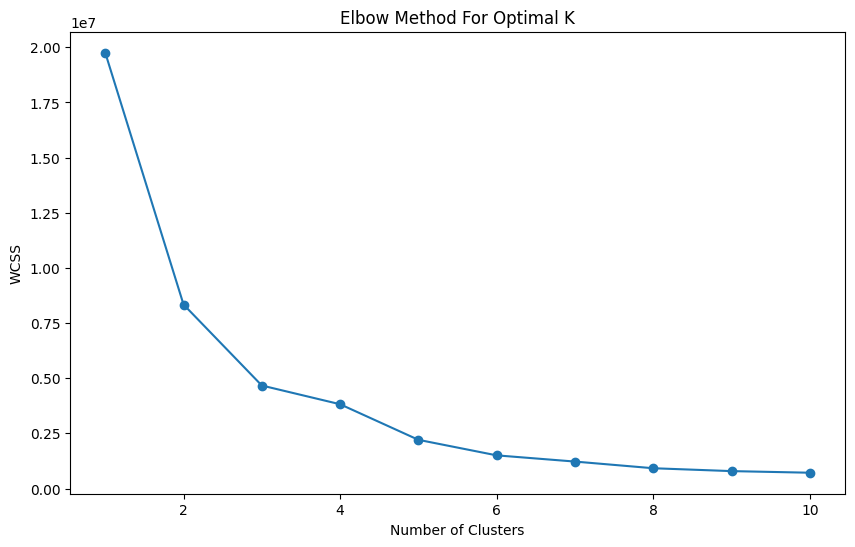

In [39]:
wcss= []
k_range = range(1,11)
for k in k_range:
    Kmeans = KMeans(n_clusters=k,random_state=42)
    Kmeans.fit(clustering_df)
    wcss.append(Kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [40]:
cluster_model = KMeans(n_clusters = 3,random_state=42)
cluster_model.fit(clustering_df)
df['cluster'] = cluster_model.labels_
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase,year,month,day,hour,frequency,recency,monetary_value,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2019,1,12,8,35,69,5288.63,0
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2019,1,12,8,35,69,5288.63,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0


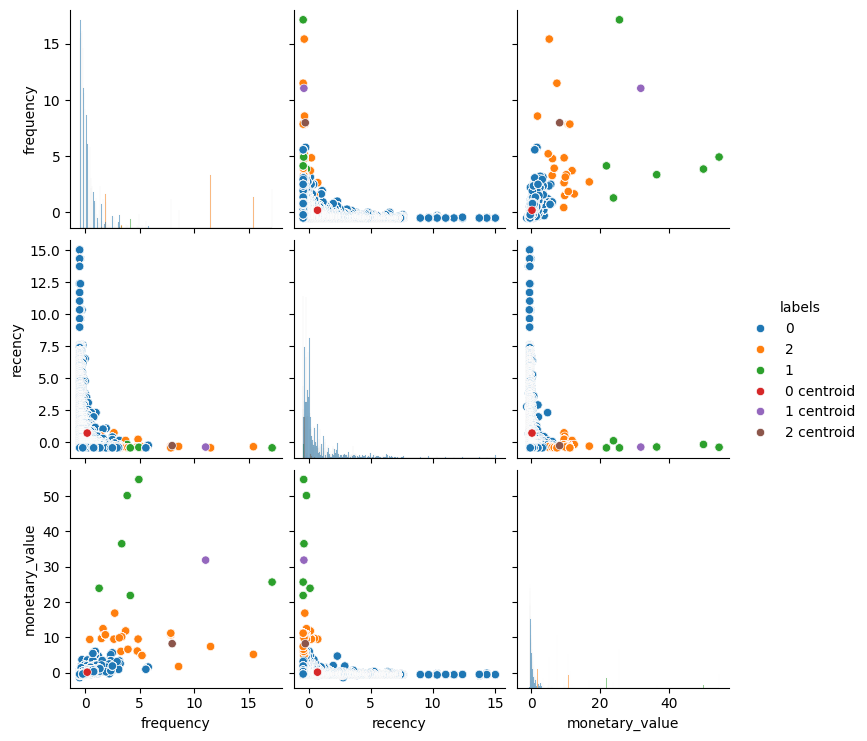

In [41]:
centroids = pd.DataFrame(cluster_model.cluster_centers_, columns=clustering_df.columns)
clustering_df['labels'] = cluster_model.labels_.astype(str)
centroids['labels']= ['0 centroid','1 centroid', '2 centroid']
df_all = pd.concat([clustering_df,centroids],ignore_index=True)
sns.pairplot(df_all,hue='labels',diag_kind='hist')

## Selección de features

In [42]:
df['churn'] = np.where(df['recency'] > 180, 1, 0)
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase,year,month,day,hour,frequency,recency,monetary_value,cluster,churn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2019,1,12,8,35,69,5288.63,0,0
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2019,1,12,8,35,69,5288.63,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5288.63,0,0


In [ ]:
#Features and target, VER DEBE COINCIDIR NUMERO DE FILAS
features = df[clustering_df]
target = df['churn']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
train_data = pd.concat([features_train, target_train], axis=1)

# Matriz de correlación
correlation_matrix = train_data.corr(method='spearman')
#ver corr parametro

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Seleccionamos las características basadas en la correlación, en caso de ser necesario, VER y PROCEDER CON LOS SIGUIENTES
threshold = 0.17
correlated_features = correlation_matrix.index[abs(correlation_matrix["target"]) > threshold].tolist()
correlated_features.remove('target')
print("Características seleccionadas:", correlated_features)

In [ ]:
# Añadir la constante para el modelo de statsmodels
X_train_stats = sm.add_constant(features_train[correlated_features].astype(float))
X_test_stats = sm.add_constant(features_valid[correlated_features].astype(float))
print(X_train_stats.head())

In [ ]:
model=sm.OLS(target_train_ohe.astype(float), X_train_stats.astype(float))
results=model.fit()
print(results.summary())

In [ ]:
# Selección de features
features_train=features_train[correlated_features]
features_valid=features_valid[correlated_features]


In [ ]:
#Indica las graficas y valores de metricas como exactitud, F1, AUC-ROC, PRC
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Modelos

### Modelo Dummy

In [ ]:
dummy_cl = DummyClassifier(strategy = 'constant', constant = 1)
dummy_cl.fit(features_train_ohe, target_train_ohe)
evaluate_model(model_lr, features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)

### Regresión Logística

In [ ]:
model_lr=LogisticRegression(solver='liblinear', random_state=12345)
model_lr.fit(features_train, target_train)
evaluate_model(model_lr, features_train, target_train, features_valid, target_valid)

In [ ]:
score_valid=
auc_roc_lr=

### Árbol de decisión

In [ ]:
model_tree = DecisionTreeClassifier()
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50, 100],
    'class_weight':[None, 'balanced'],
    'random_state':[12345]
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_tree.fit(features_train, target_train)
best_param_tree=grid_tree.best_params_


In [ ]:
print(best_param_tree)
print(grid_tree.best_score_)

In [ ]:
%time #llenar con los resultados anteriores
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=, criterion='entropy')
model_tree.fit(features_train, target_train)
evaluate_model(model_tree, features_train, target_train, features_valid, target_valid)

In [ ]:
accuracy_score_tree=
auc_roc_tree=

### Bosque aleatorio

In [ ]:
model_forest = RandomForestClassifier()
param_grid = {
    'n_estimators':[20, 50, 100, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[None, 10, 20, 30, 50],
    'class_weight':[None, 'balanced']
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_forest.fit(features_train, target_train)
best_param_forest=grid_forest.best_params_


In [ ]:
print(best_param_forest)
print(grid_forest.best_score_)

In [ ]:
%time #llenar con los resultados anteriores
model_ba = RandomForestClassifier(random_state=12345, n_estimators=, max_depth=, class_weight='balanced',
                                  criterion='entropy')
model_ba.fit(features_train, target_train)
evaluate_model(model_ba, features_train, target_train, features_valid, target_valid)

In [ ]:
score_valid_ba=
auc_roc_ba=

### LightGBM


In [ ]:
model_lgbm = LGBMClassifier()
param_grid = {
    'n_estimators':[20, 50, 100, 200, 300],
    'seed':[12345],
    'max_depth':[10, 20, 50],
    'learning_rate':[0.01, 0.05, 0.1]
}

grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
best_param_lgbm=grid_lgbm.best_params_

In [ ]:
print(best_param_lgbm)
print(grid_lgbm.best_score_)

In [ ]:
%time
model_lgbm = LGBMClassifier(n_estimators=200, seed=12345, max_depth=10, objective='binary', learning_rate=0.1)
model_lgbm.fit(features_train, target_train)
evaluate_model(model_lgbm, features_train, target_train, features_valid, target_valid)

In [ ]:
acc_scor_lgbm=
auc_roc_lgbm=

### XGBoost

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='error')
param_grid = {
    'n_estimators':[20, 50],
    'max_depth':[10, 20, 50],
    'learning_rate':[0.01, 0.05, 0.1],
    'gamma':[0, 0.1, 0.2, 0.3, 0.4]
}

grid_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_xgb.fit(features_train, target_train)
best_param_xgb=grid_xgb.best_params_

In [ ]:
print(best_param_xgb)
print(-grid_xgb.best_score_)

In [ ]:
%time
model_xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='error', 
                          n_estimators=50, seed=12345, max_depth=10 , gamma=0.4, learning_rate=0.1)
model_xgb.fit(features_train, target_train)
evaluate_model(model_xgb, features_train, target_train, features_valid, target_valid)

In [ ]:
acc_xgb=
auc_roc_xgb=

## Análisis de modelos

In [ ]:
# Se realizará un cuadro resumen 

values = [
    ['Logistic Regression', score_valid, auc_roc_lr],
    ['Decision Tree C', accuracy_score_tree, auc_roc_tree],
    ['Random Forest C', score_valid_ba, auc_roc_ba], 
    ['LightGBM C', acc_scor_lgbm, auc_roc_lgbm],
    ['XGBoost C', acc_xgb, auc_roc_xgb]]

resumen_models = pd.DataFrame(values, columns=['Model', 'Exactitud', 'AUC-ROC'])
resumen_models = resumen_models.set_index('Model')
resumen_models.sort_values(by='AUC-ROC', ascending=False)

## Conclusiones